# Explore Atlas

Code blocks to explore a statistical shape atlas. We can compute the variance explained by the shape modes, visualize the average shape, look at how each shape mode affects the mean shape, and project a new model onto the atlas to generate z-scores.

### Import python modules

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display, clear_output
import h5py as h5

### Load shape atlas

The atlas I'm using is downloaded from the [Cardiac Atlas Project website](https://www.cardiacatlas.org/biventricular-modes/).

In [2]:
# Load shape atlas
file_path_in = './' #replace with your file path

pc = h5.File(file_path_in + 'UKBRVLV_All.h5', 'r')

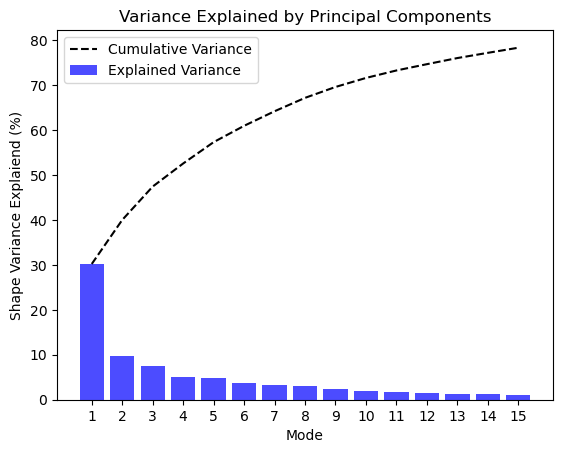

In [3]:
%matplotlib inline
# plot variance
num_modes = 15
explained_variance = pc["EXPLAINED"][0][0:num_modes]
cumulative_variance = np.cumsum(explained_variance)

# Create the figure and axis
fig, ax = plt.subplots()

# Bar chart for explained variance
pc_indices = np.arange(1, num_modes + 1)
ax.bar(pc_indices, explained_variance, alpha=0.7, color='b', label='Explained Variance')

# Line plot for cumulative variance
ax.plot(pc_indices, cumulative_variance, color='black', linestyle='dashed', label='Cumulative Variance')

# Set x-axis labels
ax.set_xticks(pc_indices)
ax.set_xticklabels(pc_indices)

# Add labels, title, and legend
ax.set_xlabel('Mode')
ax.set_ylabel('Shape Variance Explaiend (%)')
ax.set_title('Variance Explained by Principal Components')
ax.legend(loc='upper left')

# Show the plot
plt.show()
plt.close()

### Visualize Atlas Shape and Modes

In [4]:
def genModel(atlas, mode, score):
  S = np.transpose(atlas['MU']) + (score * np.sqrt(atlas['LATENT'][0,mode]) * atlas['COEFF'][mode,:])

  # get ED & ES points, & convert to 3 columns matrix [x, y, z]
  N = S.shape[1] // 2
  ed = np.reshape(S[0,:N], (-1,3))
  es = np.reshape(S[0,N:], (-1,3))
  return ed, es

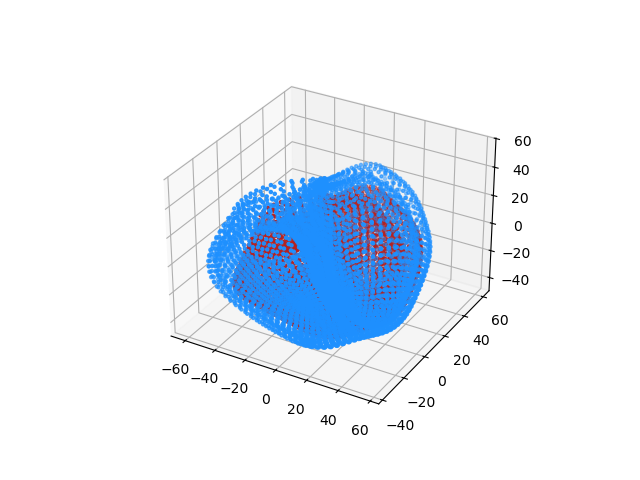

In [5]:
%matplotlib widget

# visualize average shape
ed, es = genModel(pc, 0, 0)

# plot ED points in blue and ES points in red
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ed[:,0], ed[:,1], ed[:,2], color='dodgerblue', marker='.')
ax.scatter(es[:,0], es[:,1], es[:,2], color='firebrick', marker='.')

### Visualize Modes

Widgets to visualize how changing the different shape mode scores for each shape mode will change the shape.

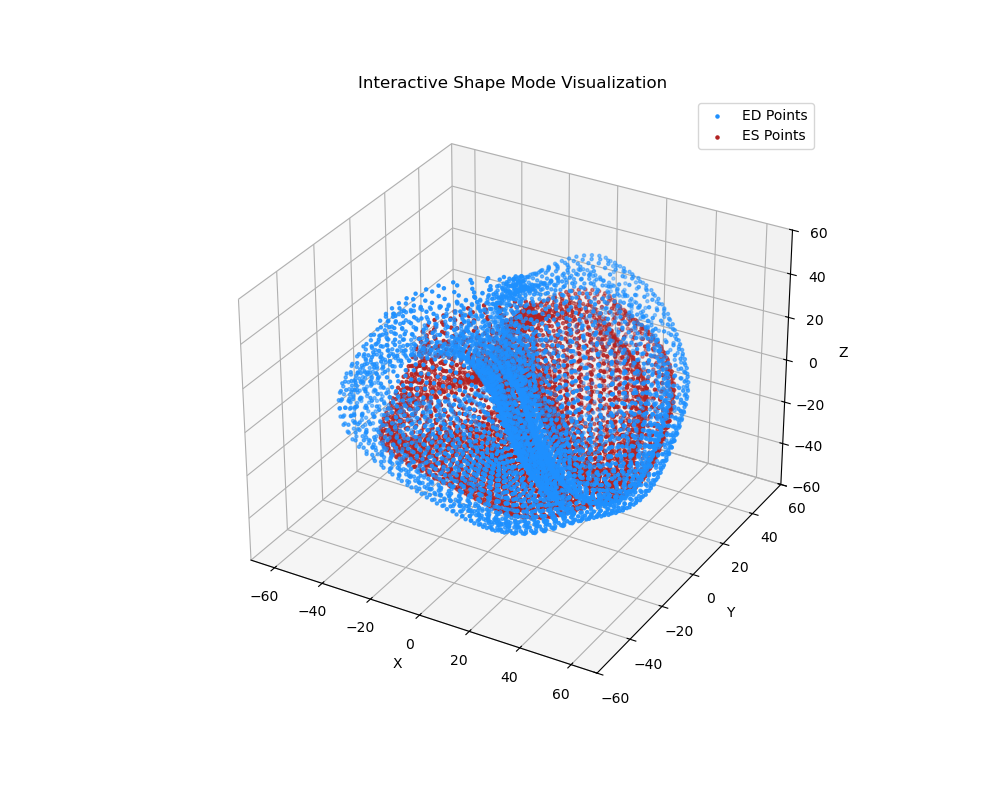

In [6]:
# for this, might need to !pip install ipympl and then restart the kernel
%matplotlib widget

# Set up the initial plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Interactive Shape Mode Visualization')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Can adust the fixed limits here for different views
ax.set_xlim(-70, 70)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)

# Initialize scatter plots with mean ED and ES shape, which will be updated by the sliders
ed, es = genModel(pc, 0, 0)
scat_ed = ax.scatter(ed[:,0], ed[:,1], ed[:,2], color='dodgerblue', marker='.', label='ED Points')
scat_es = ax.scatter(es[:,0], es[:,1], es[:,2], color='firebrick', marker='.', label='ES Points')
ax.legend()

# Function to update the plot based on widget values
def update_plot(mode=0, score=0.0):
    ed, es = genModel(pc, mode, score)
    scat_ed._offsets3d = (ed[:,0], ed[:,1], ed[:,2])
    scat_es._offsets3d = (es[:,0], es[:,1], es[:,2])
    # Redraw the canvas to reflect the changes
    fig.canvas.draw_idle()
    
# Create interactive widgets for 'Shape Mode' and 'Score'
mode_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=num_modes,
    step=1,
    description='Shape Mode:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

score_slider = widgets.FloatSlider(
    value=0.0,
    min=-3.0,
    max=3.0,
    step=0.1,
    description='Score:',
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

# Link the sliders to the update_plot function
interactive_plot = widgets.interactive_output(update_plot, {'mode': mode_slider, 'score': score_slider})

# Display the widgets and the plot in a vertical box layout
display(widgets.VBox([widgets.HBox([mode_slider, score_slider]), interactive_plot]))

### Project a Patient Onto Atlas

Example code of how we can project a patient onto the atlas to get their specific z-scores.

In [48]:
# import dummy data
example_3d_ed = np.loadtxt("Data/dummy_ed.txt")
example_3d_es = np.loadtxt("Data/dummy_es.txt")
example_1d_ed = example_3d_ed.flatten()
example_1d_es = example_3d_es.flatten()
example_flattened = np.concatenate((example_1d_ed, example_1d_es))

In [49]:
def procrustes(X,Y,scaling=True,reflection='best'):
    
    """
    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.
    d, Z, [tform] = procrustes(X, Y)
    """
    n,m = X.shape
    ny,my = Y.shape    
    muX = X.mean(0)
    muY = Y.mean(0)    
    X0 = X - muX
    Y0 = Y - muY    
    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)
    X0 /= normX
    Y0 /= normY
    if my < m:
        Y0 = np.concatenate((Y0,np.zeros(n, m-my)),0)
    A = np.dot(X0.T,Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=True)
    V = Vt.T
    T = np.dot(V,U.T)
    if reflection != 'best':
        have_reflection = np.linalg.det(T) < 0
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V,U.T)
    traceTA = s.sum()
    if scaling:
        b = traceTA*normX/normY
        d = 1-traceTA**2
        Z = normX*traceTA*np.dot(Y0,T)+muX
    else:
        b = 1
        d = 1+ssY/ssX-2*traceTA*normY/normX
        Z = normY*np.dot(Y0,T)+muX
    if my<m:
        T = T[:my,:]
    c = muX-b*np.dot(muY,T)
    # Transformation values 
    tform = {'rotation':T,'scale':b,'translation':c}
    #return d, Z, tform
    return T, c

In [50]:
def project_patient_to_atlas(patient_shape_flat, atlas, numModes = 10):
    patient3D = patient_shape_flat.reshape(-1, 3)
    mean3D = np.array(np.transpose(atlas["MU"])).reshape(-1, 3)
    # Procrustes alignment
    T, c = procrustes(mean3D, patient3D, scaling=True, reflection='best')
    patient3Daligned = np.dot(patient3D, T) + c
    patient1Daligned = patient3Daligned.flatten()

    patient1Dnormalized = patient1Daligned - np.transpose(atlas["MU"])
    projectedScores = np.dot(patient1Dnormalized, np.transpose(atlas["COEFF"][0:numModes,:])) / np.sqrt(np.array(np.transpose(atlas['LATENT'][0,0:numModes])))
    return projectedScores

In [51]:
project_patient_to_atlas(dummy_patient_shape_global, pc)

array([[ 1.499638  , -0.17085311, -1.9988406 , -0.06352359,  0.02493943,
         0.00824976, -0.05889373, -0.02764423, -0.02878647,  0.06084686]])